In [1]:
###############################################################
# Gözetimsiz Öğrenme ile Müşteri Segmentasyonu (Customer Segmentation with Unsupervised Learning)
###############################################################

In [2]:
###############################################################
# İş Problemi (Business Problem)
###############################################################

In [3]:
# Unsupervised Learning yöntemleriyle (Kmeans, Hierarchical Clustering )  müşteriler kümelere ayrılıp ve davranışları gözlemlenmek istenmektedir.

In [4]:
###############################################################
# Veri Seti Hikayesi
###############################################################

# Veri seti son alışverişlerini 2020 - 2021 yıllarında OmniChannel(hem online hem offline) olarak yapan müşterilerin geçmiş alışveriş davranışlarından
# elde edilen bilgilerden oluşmaktadır.

# 20.000 gözlem, 13 değişken

# master_id: Eşsiz müşteri numarası
# order_channel : Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile, Offline)
# last_order_channel : En son alışverişin yapıldığı kanal
# first_order_date : Müşterinin yaptığı ilk alışveriş tarihi
# last_order_date : Müşterinin yaptığı son alışveriş tarihi
# last_order_date_online : Muşterinin online platformda yaptığı son alışveriş tarihi
# last_order_date_offline : Muşterinin offline platformda yaptığı son alışveriş tarihi
# order_num_total_ever_online : Müşterinin online platformda yaptığı toplam alışveriş sayısı
# order_num_total_ever_offline : Müşterinin offline'da yaptığı toplam alışveriş sayısı
# customer_value_total_ever_offline : Müşterinin offline alışverişlerinde ödediği toplam ücret
# customer_value_total_ever_online : Müşterinin online alışverişlerinde ödediği toplam ücret
# interested_in_categories_12 : Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi
# store_type : 3 farklı companyi ifade eder. A company'sinden alışveriş yapan kişi B'dende yaptı ise A,B şeklinde yazılmıştır.

In [5]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import numpy as np

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)

In [8]:
df_ = pd.read_csv("/content/drive/MyDrive/datasets/flo_data_20k.csv")
df = df_.copy()

In [9]:
# tarih değişkenine çevirme
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [10]:
df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

In [11]:
df["recency"] = (analysis_date - df["last_order_date"]).astype('timedelta64[D]') # en son kaç gün önce alışveriş yaptı
df["tenure"] = (df["last_order_date"]-df["first_order_date"]).astype('timedelta64[D]')

In [12]:
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.00,1.00,139.99,799.38,95.00,119.00
1,19.00,2.00,159.97,1853.58,105.00,1469.00
2,3.00,2.00,189.97,395.35,186.00,366.00
3,1.00,1.00,39.99,81.98,135.00,11.00
4,1.00,1.00,49.99,159.99,86.00,582.00


In [13]:
###############################################################
# K-Means ile Müşteri Segmentasyonu
###############################################################

In [14]:
# 1. Değişkenleri standartlaştırınız.
#SKEWNESS
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


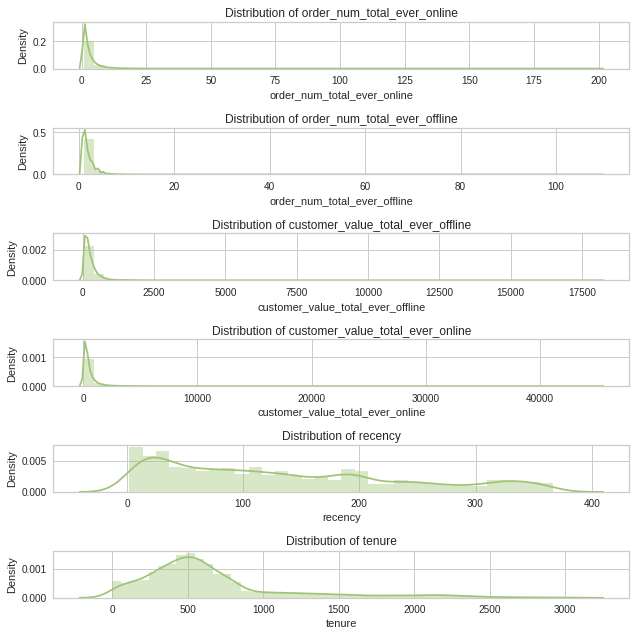

In [15]:
plt.figure(figsize=(9, 9))
plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')
plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')
plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')
plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')
plt.subplot(6, 1, 5)
check_skew(model_df,'recency')
plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)
plt.show()

In [16]:
# Normal dağılımın sağlanması için Log transformation uygulanması
model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline']=np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online']=np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency']=np.log1p(model_df['recency'])
model_df['tenure']=np.log1p(model_df['tenure'])
model_df.head()

<ipython-input-16-3b50e3581fa0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
<ipython-input-16-3b50e3581fa0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
<ipython-input-16-3b50e3581fa0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.61,0.69,4.95,6.69,4.56,4.79
1,3.00,1.10,5.08,7.53,4.66,7.29
2,1.39,1.10,5.25,5.98,5.23,5.91
3,0.69,0.69,3.71,4.42,4.91,2.48
4,0.69,0.69,3.93,5.08,4.47,6.37


In [17]:
# Scaling
sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.20,0.00,0.34,0.50,0.72,0.60
1,0.50,0.10,0.36,0.60,0.74,0.91
2,0.15,0.10,0.39,0.41,0.86,0.74
3,0.00,0.00,0.18,0.22,0.79,0.31
4,0.00,0.00,0.21,0.30,0.70,0.79


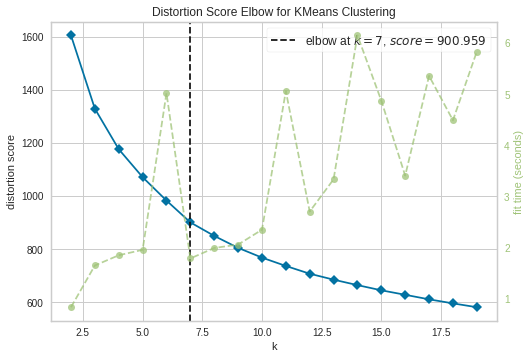

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# 2. Optimum küme sayısını belirleyiniz.
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(model_df)
elbow.show()

In [19]:
# 3. Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.
k_means = KMeans(n_clusters = 7, random_state= 42).fit(model_df)
segments=k_means.labels_
segments

array([6, 6, 6, ..., 1, 2, 0], dtype=int32)

In [20]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

<ipython-input-20-66386107fe6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = segments


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,6
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,6
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,6
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,4


In [21]:
# 4. Herbir segmenti istatistiksel olarak inceleyeniz.
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                 recency              tenure                    
                               mean  min    max                         mean  min    max                              mean    min      max                             mean    min      max    mean   min    max   mean   min     max count
segment                                                                                                                                                                                                                                    
0                              1.42 1.00   5.00                         1.28 1.00   5.00                            145.16  10.00   829.98                           210.07  12.99  1519.17  225.71 88.00 367.00 489.85 52.00 2820.00  5448
1                              2.20 1.00  12.00                         2.10 1.00  14.00                            293.82  12.99  3425.14                           377.70  23.99  3444.08   10.00  2.00  27.00 665.01  2.00 3031.00  1841
2                              1.84 1.00  13.00                         3.77 1.00 109.00                            551.78 106.82 18119.14                           283.36  14.99  2587.20  153.29 22.00 366.00 729.95 20.00 2911.00  3269
3                              1.40 1.00   8.00                         1.13 1.00   6.00                            192.39  12.99  1333.00                           250.37  19.99  3476.81  139.55  4.00 367.00  37.24  0.00  132.00   828
4                              1.61 1.00   6.00                         1.48 1.00   6.00                            185.84  12.99  1406.85                           250.00  14.00  1307.33   50.33 15.00 109.00 604.52 43.00 2828.00  3340
5                              8.63 2.00 200.00                         2.10 1.00  36.00                            278.89  12.99  3589.65                          1475.52 265.97 45220.13   32.72  2.00 109.00 966.63 18.00 3034.00  1974
6                              6.37 1.00  55.00                         1.54 1.00  16.00                            184.41  10.49  1644.79                           985.51 180.96 12038.18  180.09 55.00 367.00 943.90 26.00 2964.00  3245

In [22]:
###############################################################
# GÖREV 3: Hierarchical Clustering ile Müşteri Segmentasyonu
###############################################################

In [23]:
# 1. Görev 2'de standarlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.
hc_complete = linkage(model_df, 'complete')

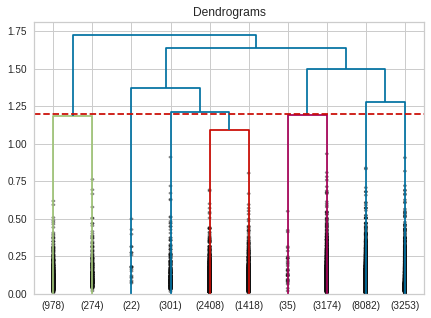

In [24]:
plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

In [25]:
# 2. Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.
hc = AgglomerativeClustering(n_clusters=5)
segments = hc.fit_predict(model_df)

In [26]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

<ipython-input-26-66386107fe6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = segments


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,0


In [27]:
# 3. Herbir segmenti istatistiksel olarak inceleyeniz.
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                customer_value_total_ever_online                 recency              tenure                     
                               mean  min    max                         mean  min    max                              mean   min      max                             mean    min      max    mean   min    max   mean    min     max count
segment                                                                                                                                                                                                                                    
0                              1.37 1.00  13.00                         1.99 1.00 109.00                            261.97 10.49 18119.14                           208.07  12.99 30688.47  183.03 18.00 367.00 569.72   3.00 2911.00  8747
1                              3.75 1.00  49.00                         1.82 1.00  24.00                            240.98 12.99  3425.14                           638.61  19.99 12545.37   23.96  2.00 108.00 715.07  18.00 3034.00  4994
2                              6.91 1.00 200.00                         3.08 1.00  16.00                            427.12 12.99  2963.24                          1104.12 139.98 45220.13  131.57 14.00 365.00 914.49 109.00 3016.00  2396
3                              1.40 1.00   6.00                         1.20 1.00   6.00                            200.69 12.99  1019.97                           227.42  26.99  1389.60   92.52  4.00 367.00  80.26   0.00  555.00   985
4                              4.74 1.00  24.00                         1.12 1.00   4.00                            123.46 10.00  1049.92                           722.77  59.98  7665.28  196.52 36.00 367.00 876.95  71.00 2964.00  2823